# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from time import time
import ssl
import certifi
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
ssl._create_default_https_context = ssl._create_unverified_context
torch.manual_seed(0)

In [2]:
BATCH_SIZE = 128

In [3]:
# Definizione delle trasformazioni per i dati
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizzazione con media e deviazione standard
])

# Caricamento del dataset KMNIST
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Creazione dei dataloader
trainloader = torch.utils.data.DataLoader(trainset, BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, BATCH_SIZE, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, BATCH_SIZE, shuffle=False)

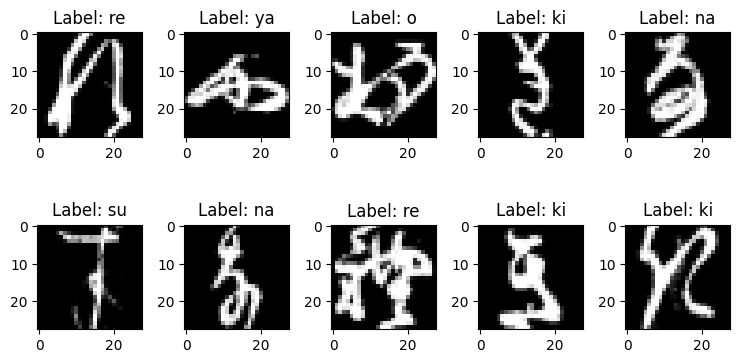

In [4]:
num_row = 2
num_col = 5

classes = trainset.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(classes[trainset.targets[i]]))
plt.tight_layout()
plt.show()

In [5]:
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [6]:
from collections import Counter
class_counts = Counter(trainset.targets.numpy())
for class_idx, count in class_counts.items():
    print(f"Classe {classes[class_idx]}: {count} occorrenze")

Classe re: 6000 occorrenze
Classe ya: 6000 occorrenze
Classe o: 6000 occorrenze
Classe ki: 6000 occorrenze
Classe na: 6000 occorrenze
Classe su: 6000 occorrenze
Classe ha: 6000 occorrenze
Classe ma: 6000 occorrenze
Classe wo: 6000 occorrenze
Classe tsu: 6000 occorrenze


In [15]:
def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer, valloader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    tr_losses = []
    te_losses = []
    tr_accs = []
    te_accs = []
    norms = []
    
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
        
        tr_losses.append(train_running_loss / i)
        tr_accs.append(train_acc/i)
        norms.append(compute_weight_norm(model))

        model.eval()
        te_ac = get_test_acc(model, valloader)
        te_l = get_test_loss(model, criterion, valloader)
        te_accs.append(te_ac)
        te_losses.append(te_l)
        print(f"Epoch: {epoch+1} | Train Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Test Loss:{te_l:.4f} | Test Accuracy {te_ac:.4f} | Time: {time()-start:.2f}") 
    return tr_losses, tr_accs, te_losses, te_accs, norms


def long_train_model(model, num_epochs,Epochs_step, trainloader, criterion, optimizer, valloader,lr_scheduler = 1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    start = time()
    tr_losses = []
    te_losses = []
    tr_accs = []
    te_accs = []
    norms = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    for epoch in tqdm(range(num_epochs), desc='Training epochs'):
        train_running_loss = 0.0
        train_acc = 0.0
        model = model.train()
        
        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
        
        ##scheduler step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for j, (images, labels) in enumerate(valloader): 
                images = images.to(device)
                labels = labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                val_loss += loss.item()
        val_loss /= (j + 1)
        scheduler.step(val_loss)

        tr_losses.append(train_running_loss / i)
        tr_accs.append(train_acc/i)
        norms.append(compute_weight_norm(model))

        model.eval()
        te_ac = get_test_acc(model,valloader)
        te_l = get_test_loss(model, criterion, valloader)
        te_accs.append(te_ac)
        te_losses.append(te_l)
        
        if (epoch+1)%Epochs_step == 0:
            print(f"Epoch: {epoch+1} | Train Loss: {loss.item():.4f} | Train Accuracy: {train_acc/i:.4f} |  Test Loss:{te_l:.4f} | Test Accuracy {te_ac:.4f} | Time: {time()-start:.2f} | Learning rate: {optimizer.param_groups[0]['lr']}")
            start = time()
    return tr_losses, tr_accs, te_losses, te_accs, norms

def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

def get_test_acc(model,loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_acc = 0.0
    for i, (images, labels) in enumerate(loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_batch_accuracy(outputs, labels)
    return test_acc/i

def get_test_loss(model, criterion, loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_running_loss = 0
    for i, (images, labels) in enumerate(loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels) 
        test_running_loss += loss.item()
    return test_running_loss/i

def graphs(tr_loss,tr_acc,te_loss,te_acc,n_epochs):
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    ax[0].plot(range(n_epochs),tr_loss,label='tr_loss', c='black')
    ax[0].plot(range(n_epochs),te_loss,label='te_loss', c='#C99700')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Test vs Train Loss')

    ax[1].plot(range(n_epochs),tr_acc,label='tr_loss', c='black')
    ax[1].plot(range(n_epochs),te_acc,label='te_loss', c='#C99700')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test vs Train Accuracy')

    ax[0].legend()
    ax[1].legend()


def wheight_map(model):
    from copy import deepcopy
    import seaborn as sns
    w = deepcopy(list(model.parameters())[0])
    fig, ax = plt.subplots(2,5, figsize=(25, 10))
    xes = [0] * 5 + [1] * 5
    yes = [0, 1, 2, 3, 4] * 2

    for i in range(10):
        sns.heatmap(w[i].reshape(28,28).detach().numpy(), 
                    cmap=sns.color_palette("coolwarm", 64), 
                    cbar=False,
                    ax=ax[xes[i], yes[i]], xticklabels=[], yticklabels=[]
                ).set_title(f"Weights for output {i}")

In [12]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN,self).__init__()
        self.l1 = nn.Linear(28*28,128)
        self.l2 = nn.Linear(128,64)
        self.l3 = nn.Linear(64,32)
        self.l4 = nn.Linear(32,10)
    
    def forward(self,x):
        x = x.flatten(start_dim = 1)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        out = self.l4(x)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) #N x 64 x 26 x26
        self.pool = nn.MaxPool2d(kernel_size= 3, stride=3)
        #self.pool=nn.MaxPool2d(kernel_size= 2, stride=2)
        self.c2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.dropout = nn.Dropout(p=0.1) 
        #self.l1 = nn.Linear(16*11*11,64)
        self.l1= nn.Linear(16*6*6, 64)
        self.l2 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.c1(x) 
        x = F.relu(x) #N x 26 x 26
        x = self.pool(x) #N x 8 x 8
        x = self.c2(x)
        x = F.relu(x)
        x = x.flatten(start_dim = 1)
        #x = self.dropout(x)
        x = self.l1(x)
        x = F.relu(x)
        out = self.l2(x)
        return out

Linear 1 hidden layer data -> 64 -> 32 -> output

Epoch: 1 | Train Loss: 0.8262 | Train Accuracy: 73.3935 | Test Loss:0.8606 | Test Accuracy 73.1370 | Time: 20.76
Epoch: 2 | Train Loss: 0.3774 | Train Accuracy: 88.5934 | Test Loss:0.6914 | Test Accuracy 79.2869 | Time: 22.79
Epoch: 3 | Train Loss: 0.3001 | Train Accuracy: 91.0741 | Test Loss:0.6000 | Test Accuracy 82.5421 | Time: 24.44
Epoch: 4 | Train Loss: 0.2518 | Train Accuracy: 92.6677 | Test Loss:0.5591 | Test Accuracy 83.9844 | Time: 22.37
Epoch: 5 | Train Loss: 0.2207 | Train Accuracy: 93.5881 | Test Loss:0.5588 | Test Accuracy 84.5152 | Time: 22.69
Epoch: 6 | Train Loss: 0.1972 | Train Accuracy: 94.1796 | Test Loss:0.5470 | Test Accuracy 85.4067 | Time: 24.01
Epoch: 7 | Train Loss: 0.1762 | Train Accuracy: 94.8234 | Test Loss:0.5188 | Test Accuracy 86.5385 | Time: 28.41
Epoch: 8 | Train Loss: 0.1612 | Train Accuracy: 95.3019 | Test Loss:0.5201 | Test Accuracy 86.7788 | Time: 37.91
Epoch: 9 | Train Loss: 0.1464 | Train Accuracy: 95.7070 | Test Loss:0.5231 | Test Accuracy 86.71

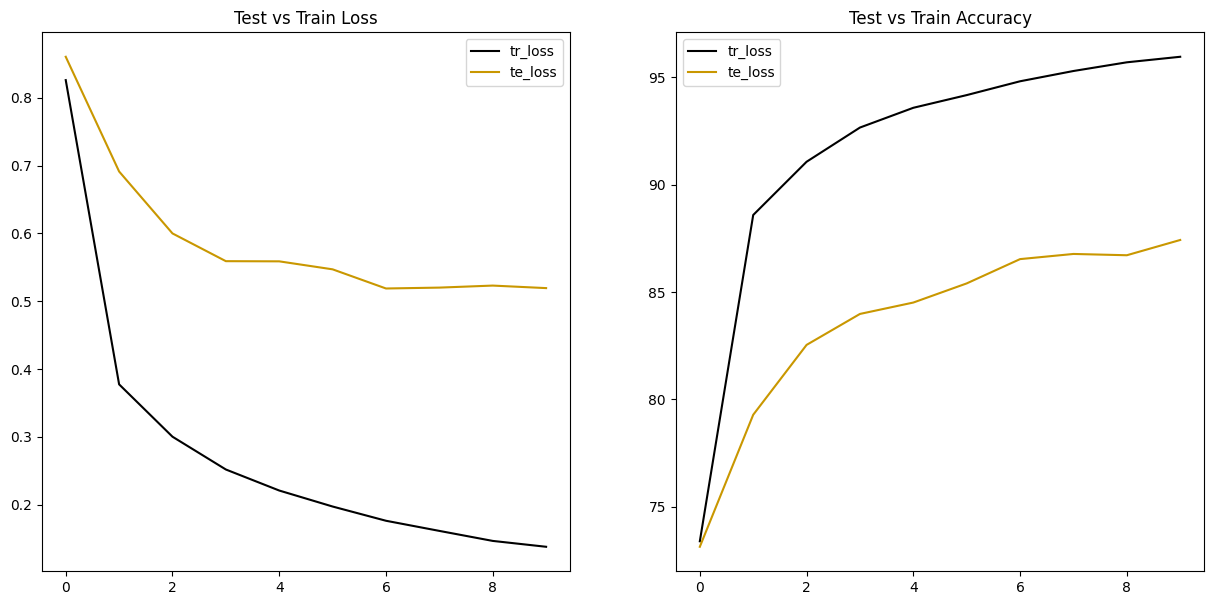

In [14]:
model = FCN()
N_Epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer, testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Linear 2 hidden layer data -> 64 -> 32 -> 16 -> output

Epoch: 1 | Train Loss: 0.8450 | Train Accuracy: 72.7086 | Test Loss:0.8643 | Test Accuracy 74.4992 | Time: 23.40
Epoch: 2 | Train Loss: 0.3919 | Train Accuracy: 88.3119 | Test Loss:0.7475 | Test Accuracy 78.4956 | Time: 22.16
Epoch: 3 | Train Loss: 0.3035 | Train Accuracy: 90.9472 | Test Loss:0.6743 | Test Accuracy 81.1198 | Time: 23.36
Epoch: 4 | Train Loss: 0.2526 | Train Accuracy: 92.6900 | Test Loss:0.5924 | Test Accuracy 83.8241 | Time: 20.82
Epoch: 5 | Train Loss: 0.2178 | Train Accuracy: 93.7094 | Test Loss:0.5581 | Test Accuracy 85.5569 | Time: 57.17
Epoch: 6 | Train Loss: 0.1943 | Train Accuracy: 94.4361 | Test Loss:0.5504 | Test Accuracy 85.6170 | Time: 53.23
Epoch: 7 | Train Loss: 0.1773 | Train Accuracy: 94.8373 | Test Loss:0.5610 | Test Accuracy 85.7171 | Time: 31.33
Epoch: 8 | Train Loss: 0.1600 | Train Accuracy: 95.3448 | Test Loss:0.5248 | Test Accuracy 86.9792 | Time: 26.44
Epoch: 9 | Train Loss: 0.1471 | Train Accuracy: 95.7543 | Test Loss:0.5341 | Test Accuracy 87.13

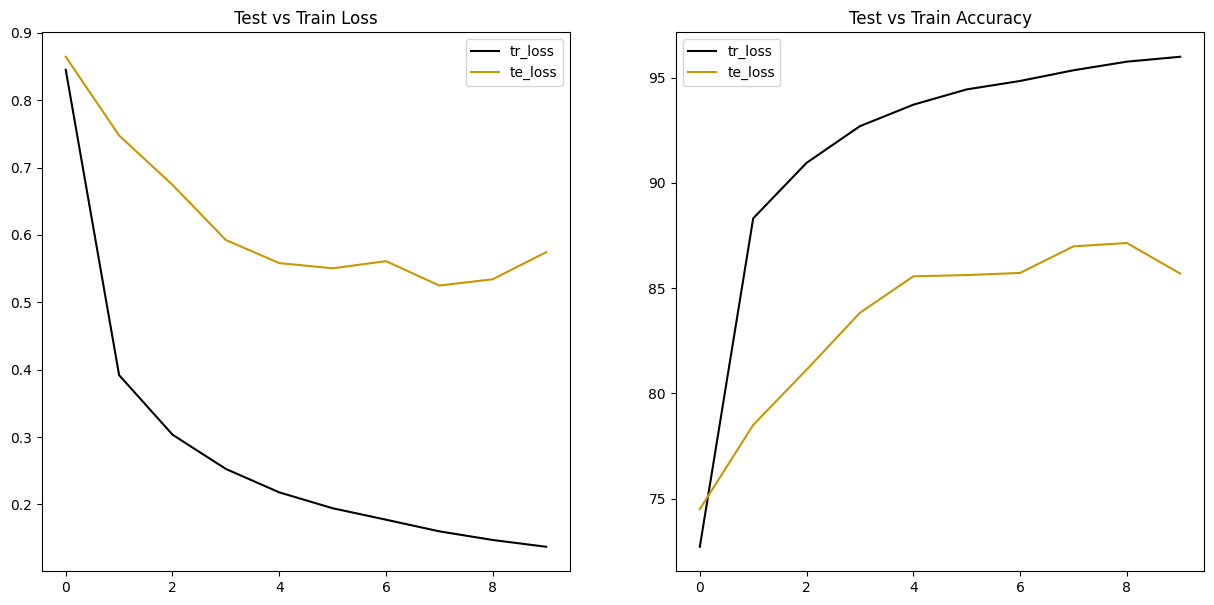

In [10]:
model = FCN()
N_Epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer, testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Linear 2 hidden layer data -> 256 -> 128 -> 64 -> output

Epoch: 1 | Train Loss: 0.6543 | Train Accuracy: 80.0753 | Test Loss:0.7465 | Test Accuracy 77.4940 | Time: 21.05
Epoch: 2 | Train Loss: 0.2989 | Train Accuracy: 90.8938 | Test Loss:0.5628 | Test Accuracy 84.0345 | Time: 21.39
Epoch: 3 | Train Loss: 0.2206 | Train Accuracy: 93.4451 | Test Loss:0.5335 | Test Accuracy 85.1162 | Time: 21.56
Epoch: 4 | Train Loss: 0.1778 | Train Accuracy: 94.8262 | Test Loss:0.4878 | Test Accuracy 87.2095 | Time: 25.66
Epoch: 5 | Train Loss: 0.1461 | Train Accuracy: 95.7321 | Test Loss:0.4748 | Test Accuracy 87.8005 | Time: 23.21
Epoch: 6 | Train Loss: 0.1188 | Train Accuracy: 96.5873 | Test Loss:0.4286 | Test Accuracy 89.0725 | Time: 21.97
Epoch: 7 | Train Loss: 0.1041 | Train Accuracy: 96.9874 | Test Loss:0.4896 | Test Accuracy 88.4115 | Time: 21.37
Epoch: 8 | Train Loss: 0.0907 | Train Accuracy: 97.4370 | Test Loss:0.4606 | Test Accuracy 89.1526 | Time: 21.46
Epoch: 9 | Train Loss: 0.0802 | Train Accuracy: 97.6574 | Test Loss:0.4777 | Test Accuracy 89.52

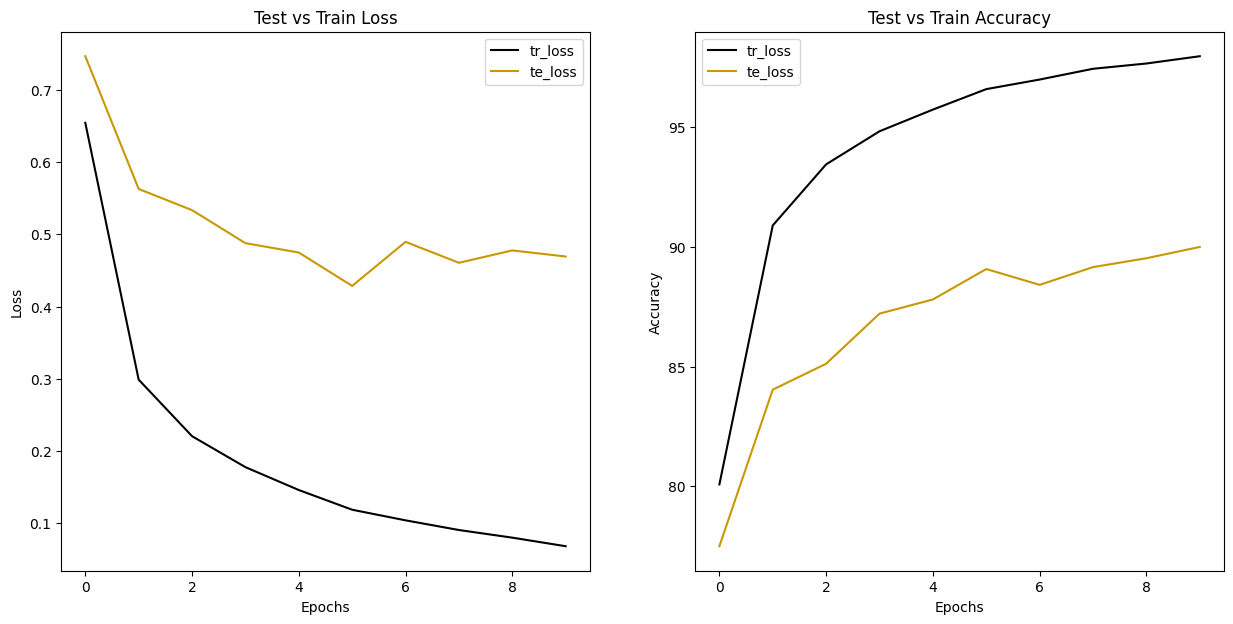

In [16]:
model = FCN()
N_Epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer, testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Convolutional 1 hidden layers data -> 32 channel -> 64 -> output

Epoch: 1 | Train Loss: 0.5692 | Train Accuracy: 83.0991 | Test Loss:0.6458 | Test Accuracy 81.6406 | Time: 50.02
Epoch: 2 | Train Loss: 0.2384 | Train Accuracy: 93.2720 | Test Loss:0.4964 | Test Accuracy 86.0276 | Time: 41.12
Epoch: 3 | Train Loss: 0.1648 | Train Accuracy: 95.3531 | Test Loss:0.4373 | Test Accuracy 88.7320 | Time: 42.56
Epoch: 4 | Train Loss: 0.1221 | Train Accuracy: 96.5651 | Test Loss:0.4455 | Test Accuracy 88.6418 | Time: 41.77
Epoch: 5 | Train Loss: 0.0902 | Train Accuracy: 97.5711 | Test Loss:0.4462 | Test Accuracy 89.0925 | Time: 55.30
Epoch: 6 | Train Loss: 0.0669 | Train Accuracy: 98.3379 | Test Loss:0.4402 | Test Accuracy 90.2143 | Time: 52.26
Epoch: 7 | Train Loss: 0.0485 | Train Accuracy: 98.8331 | Test Loss:0.4789 | Test Accuracy 89.8037 | Time: 41.27
Epoch: 8 | Train Loss: 0.0377 | Train Accuracy: 99.0852 | Test Loss:0.4791 | Test Accuracy 90.0441 | Time: 44.55
Epoch: 9 | Train Loss: 0.0255 | Train Accuracy: 99.4836 | Test Loss:0.5464 | Test Accuracy 89.97

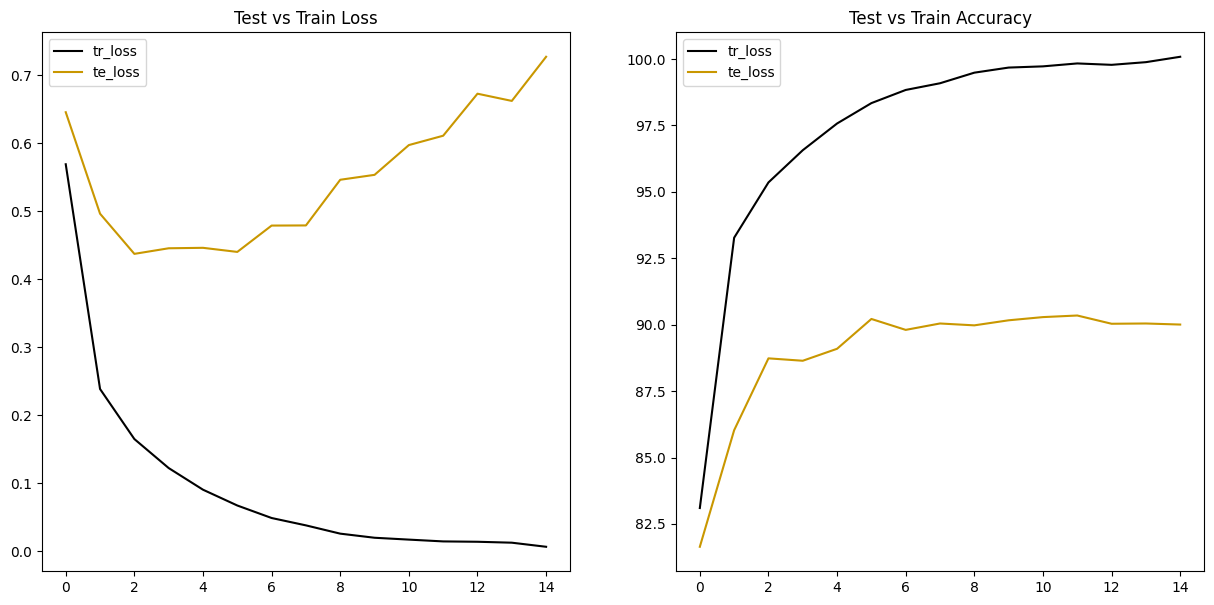

In [16]:
model = CNN()
N_Epochs = 15
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer,testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Convolutional 2 hidden layers  data -> 32 -> 16 -> 64 -> output

Epoch: 1 | Train Loss: 0.3572 | Train Accuracy: 89.4119 | Test Loss:0.3856 | Test Accuracy 89.9239 | Time: 50.11
Epoch: 2 | Train Loss: 0.1224 | Train Accuracy: 96.6057 | Test Loss:0.2964 | Test Accuracy 93.0689 | Time: 46.06
Epoch: 3 | Train Loss: 0.0725 | Train Accuracy: 98.0814 | Test Loss:0.2988 | Test Accuracy 93.6498 | Time: 52.01
Epoch: 4 | Train Loss: 0.0447 | Train Accuracy: 98.8370 | Test Loss:0.2941 | Test Accuracy 94.0104 | Time: 53.33
Epoch: 5 | Train Loss: 0.0286 | Train Accuracy: 99.3267 | Test Loss:0.3254 | Test Accuracy 94.0004 | Time: 51.86
Epoch: 6 | Train Loss: 0.0194 | Train Accuracy: 99.6077 | Test Loss:0.3360 | Test Accuracy 94.3710 | Time: 47.07
Epoch: 7 | Train Loss: 0.0149 | Train Accuracy: 99.7307 | Test Loss:0.3729 | Test Accuracy 94.1206 | Time: 49.47
Epoch: 8 | Train Loss: 0.0137 | Train Accuracy: 99.7529 | Test Loss:0.3888 | Test Accuracy 93.8301 | Time: 51.07
Epoch: 9 | Train Loss: 0.0109 | Train Accuracy: 99.8698 | Test Loss:0.4608 | Test Accuracy 93.82

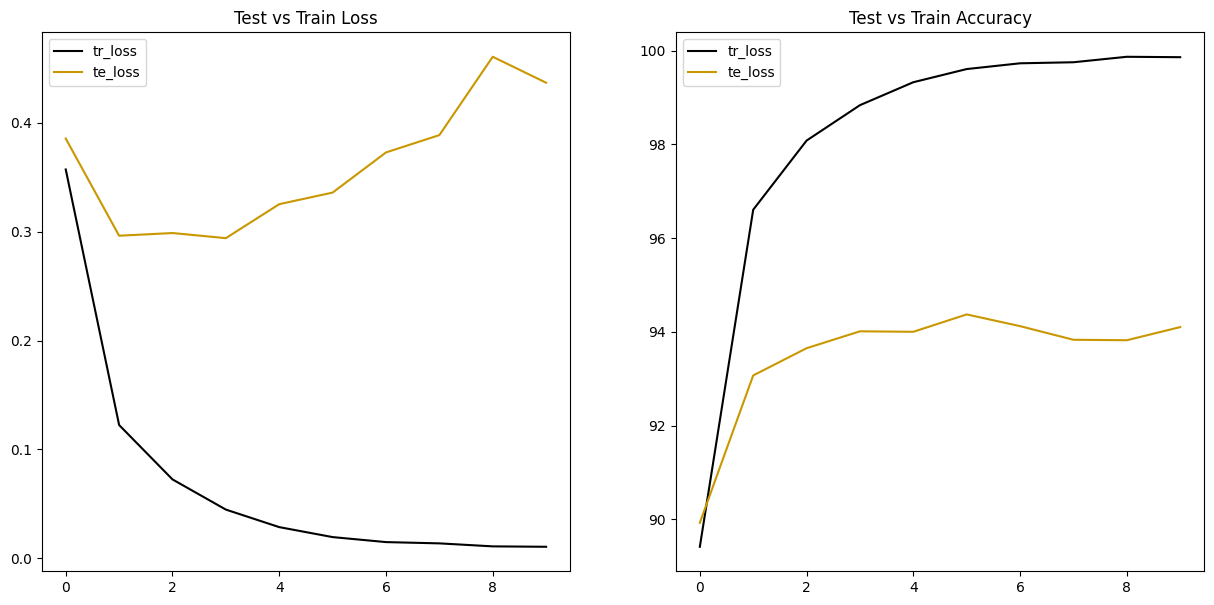

In [20]:
model = CNN()
N_Epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer,testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Convolutional 2 hidden layers with pooling data -> 32 -> 2 maxpooling -> 16 -> 64 -> output

Epoch: 1 | Train Loss: 0.6634 | Train Accuracy: 79.6769 | Test Loss:0.6606 | Test Accuracy 81.1799 | Time: 40.78
Epoch: 2 | Train Loss: 0.2474 | Train Accuracy: 92.7334 | Test Loss:0.5117 | Test Accuracy 85.5369 | Time: 37.25
Epoch: 3 | Train Loss: 0.1722 | Train Accuracy: 95.0154 | Test Loss:0.3987 | Test Accuracy 89.5533 | Time: 34.19
Epoch: 4 | Train Loss: 0.1339 | Train Accuracy: 96.2212 | Test Loss:0.3796 | Test Accuracy 89.9439 | Time: 34.39
Epoch: 5 | Train Loss: 0.1090 | Train Accuracy: 96.9440 | Test Loss:0.3205 | Test Accuracy 92.3377 | Time: 36.16
Epoch: 6 | Train Loss: 0.0927 | Train Accuracy: 97.4109 | Test Loss:0.3215 | Test Accuracy 92.2276 | Time: 34.99
Epoch: 7 | Train Loss: 0.0802 | Train Accuracy: 97.7670 | Test Loss:0.2983 | Test Accuracy 93.0889 | Time: 33.26
Epoch: 8 | Train Loss: 0.0685 | Train Accuracy: 98.1643 | Test Loss:0.2873 | Test Accuracy 93.7600 | Time: 34.09
Epoch: 9 | Train Loss: 0.0609 | Train Accuracy: 98.3474 | Test Loss:0.3135 | Test Accuracy 93.17

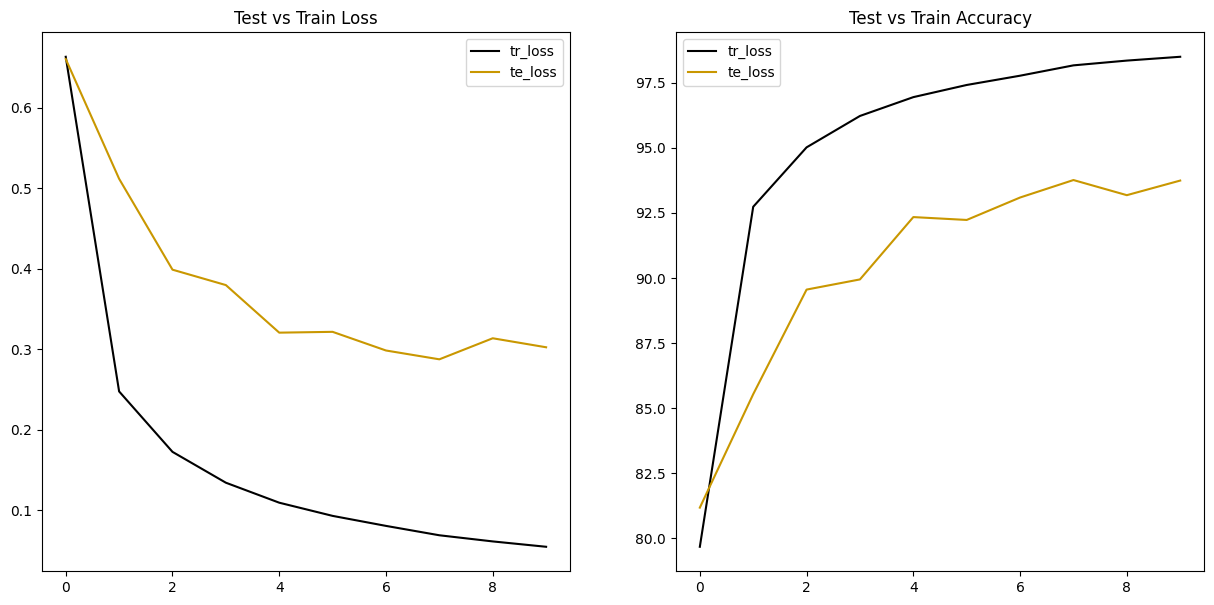

In [34]:
model = CNN()
N_Epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer,testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Convolutional 2 hidden layers with pooling data -> 32 channel -> 3 maxpooling -> 16 channel -> 64 -> output

Epoch: 1 | Train Loss: 0.6249 | Train Accuracy: 81.1599 | Test Loss:0.6660 | Test Accuracy 81.2400 | Time: 33.10
Epoch: 2 | Train Loss: 0.2262 | Train Accuracy: 93.4300 | Test Loss:0.4627 | Test Accuracy 87.8706 | Time: 32.87
Epoch: 3 | Train Loss: 0.1489 | Train Accuracy: 95.8127 | Test Loss:0.3720 | Test Accuracy 90.5449 | Time: 33.52
Epoch: 4 | Train Loss: 0.1146 | Train Accuracy: 96.8322 | Test Loss:0.3143 | Test Accuracy 92.2476 | Time: 32.61
Epoch: 5 | Train Loss: 0.0911 | Train Accuracy: 97.4971 | Test Loss:0.3243 | Test Accuracy 92.3177 | Time: 32.78
Epoch: 6 | Train Loss: 0.0771 | Train Accuracy: 97.9078 | Test Loss:0.2749 | Test Accuracy 93.7300 | Time: 34.92
Epoch: 7 | Train Loss: 0.0645 | Train Accuracy: 98.2199 | Test Loss:0.2580 | Test Accuracy 94.2508 | Time: 32.38
Epoch: 8 | Train Loss: 0.0566 | Train Accuracy: 98.4826 | Test Loss:0.2534 | Test Accuracy 94.5112 | Time: 34.33
Epoch: 9 | Train Loss: 0.0498 | Train Accuracy: 98.7057 | Test Loss:0.2479 | Test Accuracy 94.77

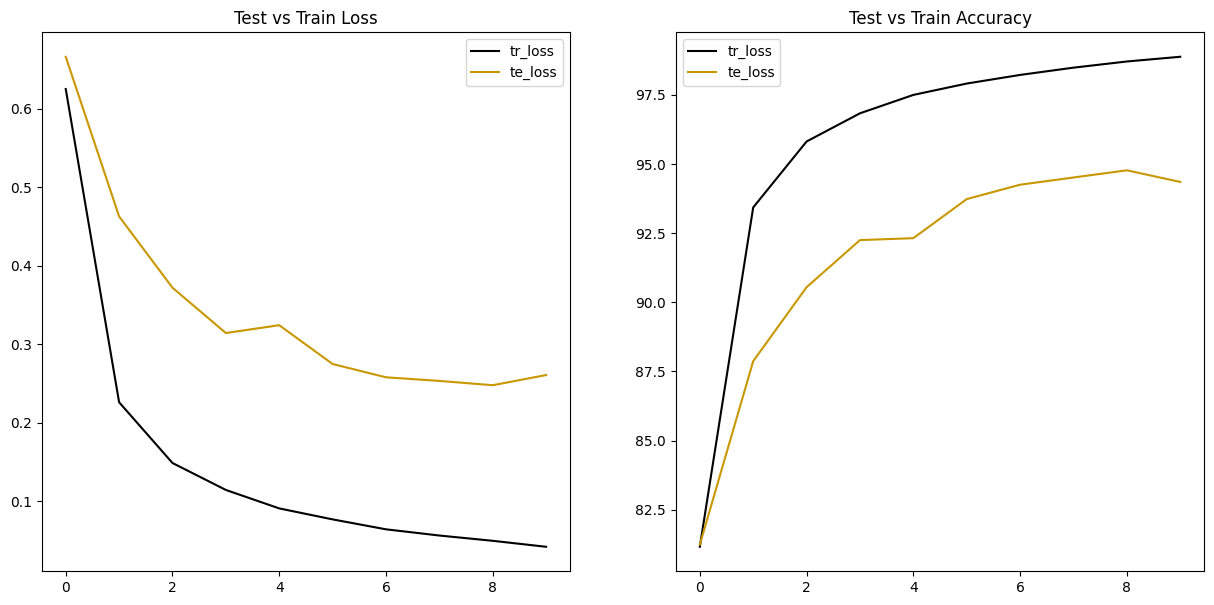

In [35]:
model = CNN()
N_Epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer,testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Convolutional 2 hidden layers with pooling data -> 32 channel -> 3 maxpooling -> 16 channel -> 64 -> output. With regularization

Epoch: 1 | Train Loss: 0.6116 | Train Accuracy: 81.4642 | Test Loss:0.6069 | Test Accuracy 81.8710 | Time: 36.98
Epoch: 2 | Train Loss: 0.2204 | Train Accuracy: 93.6638 | Test Loss:0.4324 | Test Accuracy 88.4916 | Time: 33.77
Epoch: 3 | Train Loss: 0.1485 | Train Accuracy: 95.8495 | Test Loss:0.3583 | Test Accuracy 90.9255 | Time: 34.30
Epoch: 4 | Train Loss: 0.1169 | Train Accuracy: 96.8110 | Test Loss:0.3174 | Test Accuracy 92.1274 | Time: 34.29
Epoch: 5 | Train Loss: 0.0990 | Train Accuracy: 97.2523 | Test Loss:0.3172 | Test Accuracy 92.0072 | Time: 34.63
Epoch: 6 | Train Loss: 0.0886 | Train Accuracy: 97.5973 | Test Loss:0.3126 | Test Accuracy 92.3778 | Time: 35.25
Epoch: 7 | Train Loss: 0.0770 | Train Accuracy: 97.9896 | Test Loss:0.2680 | Test Accuracy 93.8001 | Time: 35.00
Epoch: 8 | Train Loss: 0.0720 | Train Accuracy: 98.0842 | Test Loss:0.2844 | Test Accuracy 93.3093 | Time: 34.74
Epoch: 9 | Train Loss: 0.0635 | Train Accuracy: 98.3780 | Test Loss:0.2523 | Test Accuracy 93.95

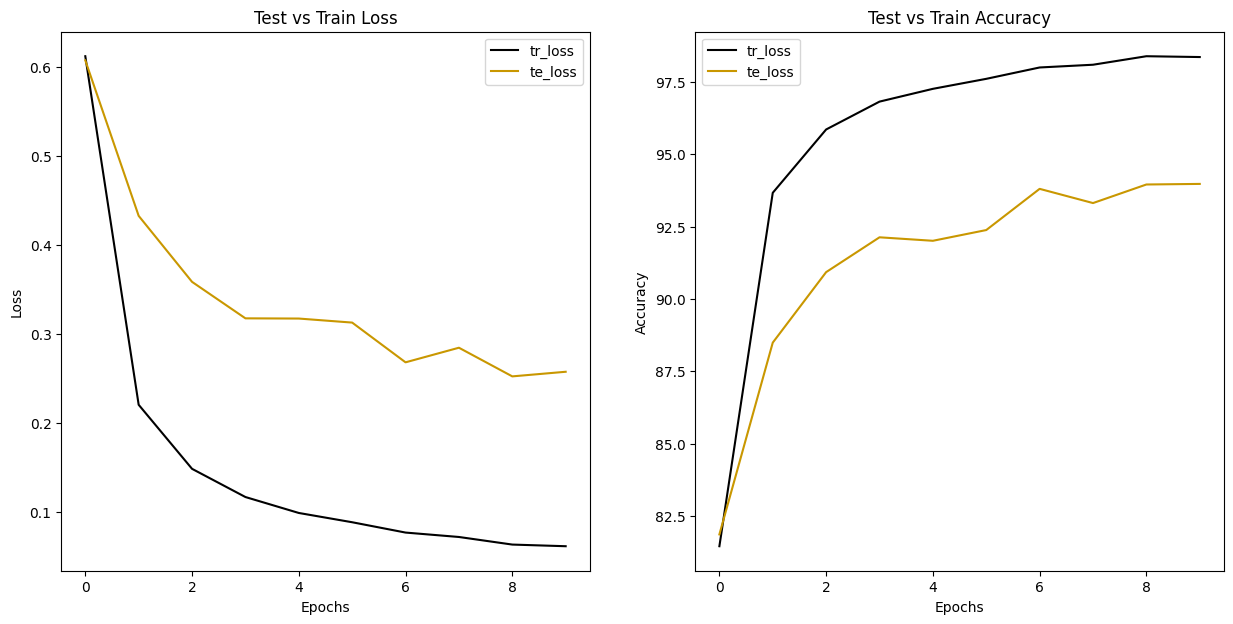

In [18]:
model = CNN()
N_Epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer,testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Convolutional 2 hidden layers with pooling data -> 32 channel -> 3 maxpooling -> 16 channel -> 64 -> output. With Dropout = 0.1

Epoch: 1 | Train Loss: 0.5996 | Train Accuracy: 81.6245 | Test Loss:0.6127 | Test Accuracy 82.6022 | Time: 35.97
Epoch: 2 | Train Loss: 0.2111 | Train Accuracy: 93.8563 | Test Loss:0.4717 | Test Accuracy 86.7889 | Time: 32.55
Epoch: 3 | Train Loss: 0.1439 | Train Accuracy: 95.9146 | Test Loss:0.3540 | Test Accuracy 91.0357 | Time: 33.39
Epoch: 4 | Train Loss: 0.1130 | Train Accuracy: 96.8744 | Test Loss:0.3118 | Test Accuracy 92.4679 | Time: 33.68
Epoch: 5 | Train Loss: 0.0920 | Train Accuracy: 97.4671 | Test Loss:0.3001 | Test Accuracy 92.9487 | Time: 32.47
Epoch: 6 | Train Loss: 0.0761 | Train Accuracy: 97.9339 | Test Loss:0.2912 | Test Accuracy 93.4295 | Time: 34.48
Epoch: 7 | Train Loss: 0.0656 | Train Accuracy: 98.2789 | Test Loss:0.2932 | Test Accuracy 93.5397 | Time: 33.45
Epoch: 8 | Train Loss: 0.0567 | Train Accuracy: 98.4481 | Test Loss:0.2526 | Test Accuracy 94.5312 | Time: 33.85
Epoch: 9 | Train Loss: 0.0486 | Train Accuracy: 98.7274 | Test Loss:0.2724 | Test Accuracy 93.77

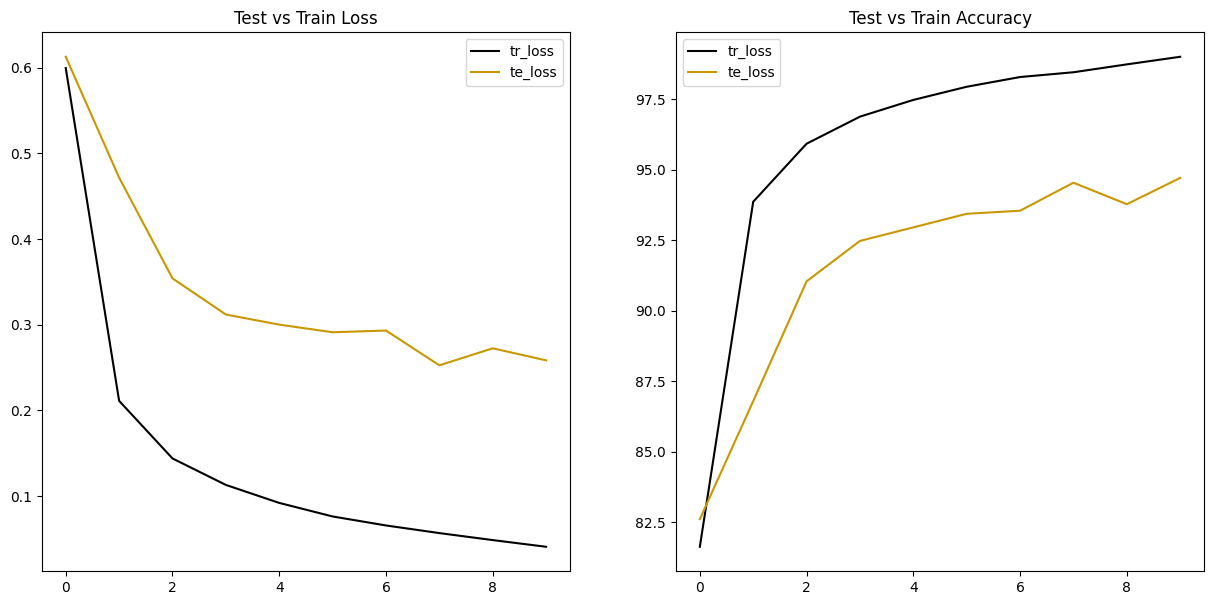

In [33]:
model = CNN()
N_Epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tr_loss,tr_accs,te_loss,te_accs,_ = train_model(model, N_Epochs, trainloader,criterion, optimizer,testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))

Best model so far for long time

Training epochs:  33%|███▎      | 10/30 [07:38<17:11, 51.58s/it]

Epoch: 10 | Train Loss: 0.2673 | Train Accuracy: 99.2054 |  Test Loss:0.2526 | Test Accuracy 95.2224 | Time: 458.99 | Learning rate: 0.001


Training epochs:  67%|██████▋   | 20/30 [15:52<07:56, 47.70s/it]

Epoch: 20 | Train Loss: 0.2444 | Train Accuracy: 100.1953 |  Test Loss:0.2875 | Test Accuracy 95.8834 | Time: 493.69 | Learning rate: 1e-05


Training epochs: 100%|██████████| 30/30 [24:41<00:00, 49.37s/it]

Epoch: 30 | Train Loss: 0.2211 | Train Accuracy: 100.2037 |  Test Loss:0.2898 | Test Accuracy 95.9435 | Time: 528.46 | Learning rate: 1.0000000000000002e-06


95.94350961538461


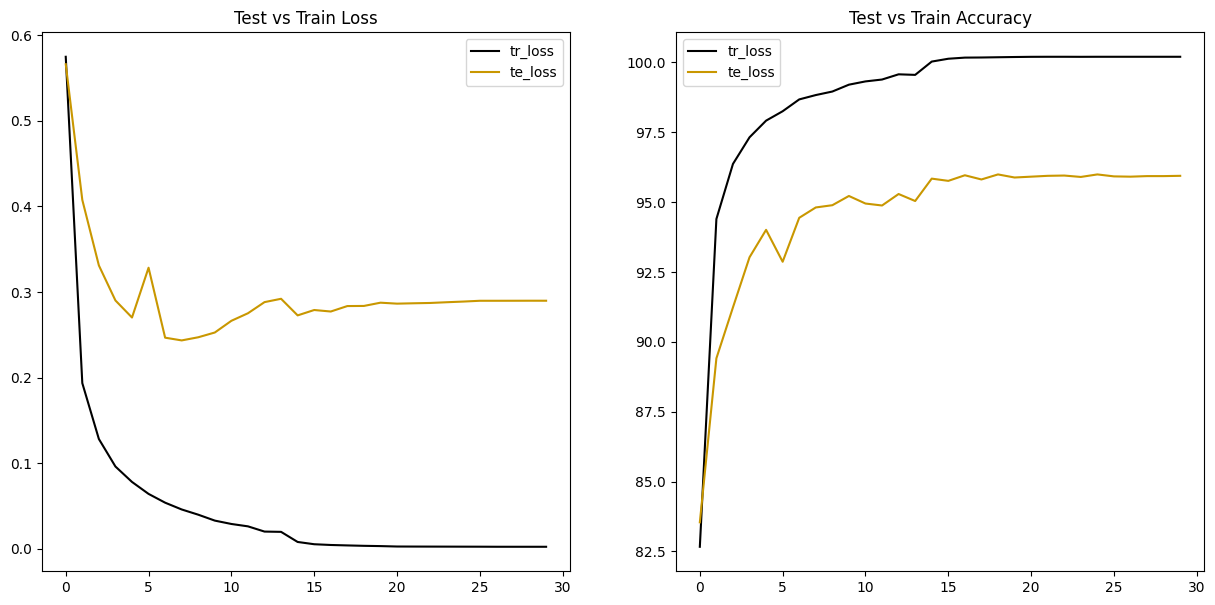

In [31]:
model = CNN()
N_Epochs = 30
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,)
tr_loss,tr_accs,te_loss,te_accs,_ = long_train_model(model, N_Epochs, 10,trainloader,criterion, optimizer,testloader)
graphs(tr_loss,tr_accs,te_loss,te_accs,N_Epochs)
print(get_test_acc(model,testloader))